In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import shap
from sklearn.inspection import permutation_importance


In [16]:
credit_data = pd.read_csv('../Data/synth_dataset.csv')

n_features = 5    # number of features
feature_names = [f'X{i+1}' for i in range(n_features)]

true_weights = {
    'X1': 3.0,   # High importance
    'X2': 1.5,   # Medium importance
    'X3': 1.0,   # Medium importance
    'X4': 0.0,   # No importance
    'X5': 0.0    # No importance
}

bias = -1.0  # intercept term

In [11]:
# 10. Split into train/test
train_data, test_data = train_test_split(credit_data, test_size=0.3, random_state=42)
X_train = train_data[feature_names]
y_train = train_data['default']
X_test = test_data[feature_names]
y_test = test_data['default']

In [12]:
# 11. Train XGBoost model
xgb_model = XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

c:\Users\usuario\anaconda3\envs\TFM_MUGRF\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:51:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
# Predict and evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Test Accuracy: 0.854


In [14]:
# 12. Train Deep Learning model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


c:\Users\usuario\anaconda3\envs\TFM_MUGRF\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.5853 - val_accuracy: 0.8643 - val_loss: 0.3205
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.3336 - val_accuracy: 0.8771 - val_loss: 0.3034
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8555 - loss: 0.3063 - val_accuracy: 0.8714 - val_loss: 0.2969
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8373 - loss: 0.3352 - val_accuracy: 0.8714 - val_loss: 0.2946
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.3062 - val_accuracy: 0.8743 - val_loss: 0.2959
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8569 - loss: 0.3010 - val_accuracy: 0.8757 - val_loss: 0.2936
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.3058 - val_accuracy: 0.8757 - val_loss: 0.2926
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8406 - loss: 0.3166 - val_accuracy: 0.8771 - val_loss: 0.2

In [15]:
# Predict and evaluate Neural Network
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)
print("Neural Network Test Accuracy:", accuracy_score(y_test, y_pred_nn))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network Test Accuracy: 0.8613333333333333


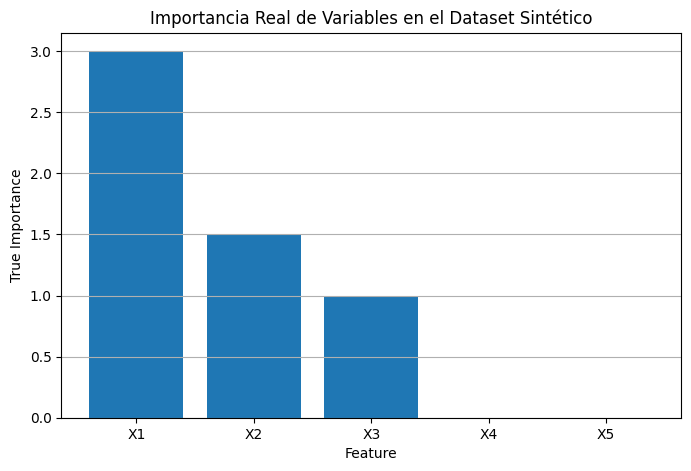

In [18]:
# 13. Plot True Feature Importances
true_importance_df = pd.DataFrame({
    'Feature': list(true_weights.keys()),
    'True Importance': list(true_weights.values())
}).sort_values(by='True Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(true_importance_df['Feature'], true_importance_df['True Importance'])
plt.xlabel('Feature')
plt.ylabel('True Importance')
plt.title('Importancia Real de Variables en el Dataset Sintético')
plt.grid(axis='y')
plt.show()

In [23]:
# 14. SHAP values for XGBoost
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)
shap_importance = np.abs(shap_values.values).mean(axis=0)

shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': shap_importance
}).sort_values(by='SHAP Importance', ascending=False)

In [25]:
# 15. Permutation Feature Importance for XGBoost
perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Permutation Importance': perm_importance.importances_mean
}).sort_values(by='Permutation Importance', ascending=False)

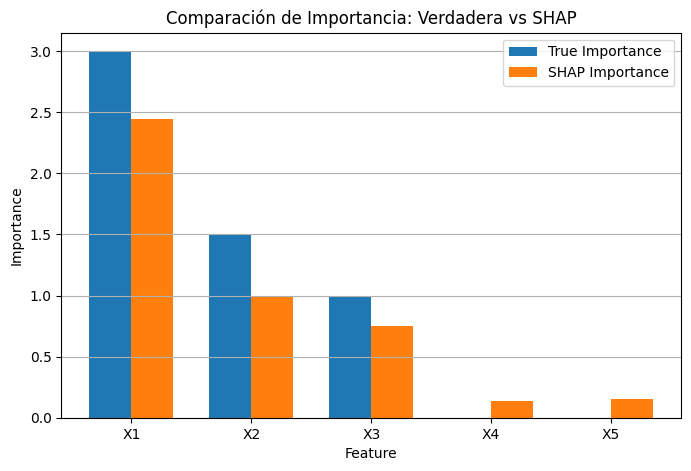

In [26]:
# 16. Plot Comparison: True vs SHAP
merged_shap = pd.merge(true_importance_df, shap_importance_df, on='Feature')

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(merged_shap))

plt.bar(index, merged_shap['True Importance'], bar_width, label='True Importance')
plt.bar(index + bar_width, merged_shap['SHAP Importance'], bar_width, label='SHAP Importance')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Comparación de Importancia: Verdadera vs SHAP')
plt.xticks(index + bar_width / 2, merged_shap['Feature'])
plt.legend()
plt.grid(axis='y')
plt.show()

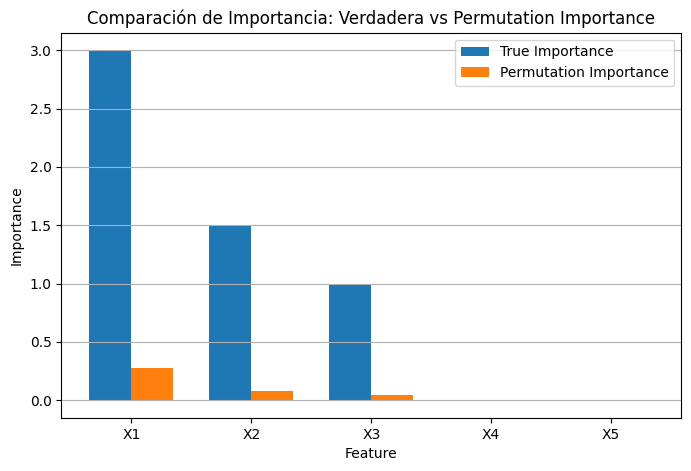

In [27]:
# 17. Plot Comparison: True vs Permutation Importance
merged_perm = pd.merge(true_importance_df, perm_importance_df, on='Feature')

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(merged_perm))

plt.bar(index, merged_perm['True Importance'], bar_width, label='True Importance')
plt.bar(index + bar_width, merged_perm['Permutation Importance'], bar_width, label='Permutation Importance')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Comparación de Importancia: Verdadera vs Permutation Importance')
plt.xticks(index + bar_width / 2, merged_perm['Feature'])
plt.legend()
plt.grid(axis='y')
plt.show()